#### Testing out Gibbs zig-zag code:

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot

In [2]:
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [3]:
d, Nobs = 20, 100
p = 1e-1
X = rand(Normal(), d, Nobs) .* rand(Binomial(1,p), d, Nobs)
X[1,:] = ones(Nobs)
ξ_true = rand(Normal(),d).* rand(Binomial(1,0.5), d)
ξ_true[1] = rand(Normal())
y = [rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] + 0. for j in 1:Nobs];
mb_size = 10
σ02 = 1

# prior = HS_prior(d, σ02) 
# prior = GDP_prior(d, σ02)
prior = gaussian_prior_nh(zeros(d), 10*rand(d))

gaussian_prior_nh([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2.51585, 7.59074, 8.79964, 0.864142, 3.82662, 4.40427, 6.35276, 5.18811, 2.9994, 2.97151, 9.81042, 5.31376, 9.3165, 7.52784, 6.61306, 9.59488, 6.13439, 5.83312, 8.62721, 6.18975])

In [4]:
my_ll = ll_logistic(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [16]:
# Sub-Sampling with control variate and with weights
ϵ = 1e-2
weights_cv = zeros(d, Nobs)
for n in 1:Nobs
    weights_cv[:,n] = [abs.(X[i,n])*norm(X[:,n]) for i in 1:d] + ϵ
end
weights_cv ./= sum(weights_cv,2);mbs = [wumbsampler(Nobs, mb_size, weights_cv[i,:]) for i in 1:d];
gs_list = cvmbsampler_list(my_model, mbs, root);

In [17]:
A = eye(d)
adapt_speed = false
opf = projopf(A, 100, adapt_speed, hyperparam_size(prior))
opt = maxa_opt(10^6)
outp = outputscheduler(opf,opt);

In [18]:
outp.opf.adapt_speed

false

In [19]:
bb = linear_bound(my_model.ll, my_model.pr, gs_list, zz_state(opf))
update_bound(bb, my_ll, prior, gs_list, zz_state(opf));

In [20]:
print("Initial speed = ", opf.alpha_skeleton[:,opf.tcounter+1])

Initial speed = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [21]:
my_zz_sampler = zz_sampler(0, gs_list, bb)
hyper_sampler = block_gibbs_sampler(1.)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [22]:
start = time()
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler})
print( round((time()-start)/60, 2), " mins")

2.11 mins

In [23]:
size(outp.opf.alpha_skeleton), size(outp.opf.xi_skeleton)

((20, 22372), (20, 22372))

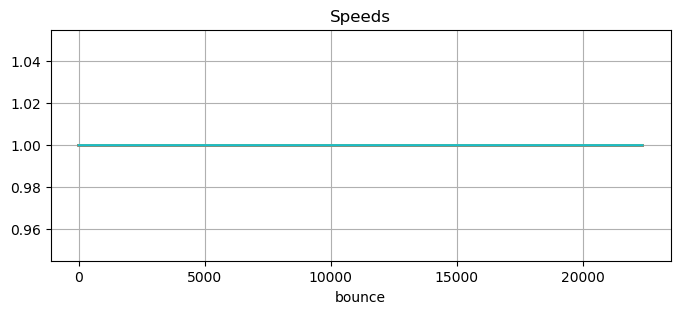

In [24]:
fig = figure("pyplot_barplot",figsize=(8,3))
for i in 1:d 
    plot((outp.opf.alpha_skeleton[i,:]))
end
title("Speeds")
xlabel("bounce")
# ylim(0,4000)
grid(true)

In [25]:
discard = 2000
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear");
hyper_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[end]/n_samples, 
                                "constant");

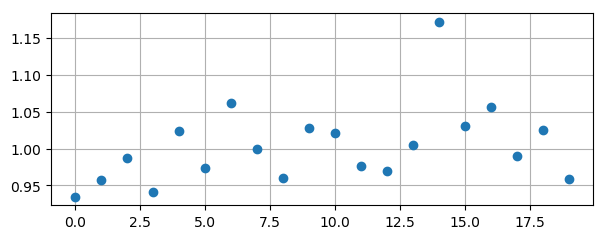

In [26]:
fig = figure("pyplot_barplot",figsize=(7,2.5))
plot([compute_configT(my_model, xi_samples[:,1:end-1], hyper_samples[:,1:end-1], k) for k in 1:d], "o")
grid(true)